In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import os
#define a regression model with Keras 
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, Reshape, Conv1D, MaxPooling1D, UpSampling1D, Concatenate, Add
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History, Callback
import matplotlib.pyplot as plt

def extract_suffixes(folder_path, index):
    """ Extracts numeric suffixes from the filenames in the given folder. """
    data_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    suffixes = set(int(f.split('_')[index].split('.')[0]) for f in data_files)
    return suffixes

def get_common_suffixes(folder1, folder2, index1, index2):
    """ Finds common numeric suffixes between two folders. """
    suffixes1 = extract_suffixes(folder1, index1)
    suffixes2 = extract_suffixes(folder2, index2)
    common_suffixes = suffixes1.intersection(suffixes2)
    return common_suffixes

def load_files(folder_path, common_suffixes, index, transpose=False):
    """ Loads files that have a suffix in the common suffix list. """
    data_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    # Filter files by the common suffixes
    data_files = [f for f in data_files if int(f.split('_')[index].split('.')[0]) in common_suffixes]
    data_files.sort(key=lambda f: int(f.split('_')[index].split('.')[0]))
    
    reshaped_data_list = []
    for data_file in data_files:
        data_path = os.path.join(folder_path, data_file)
        data = np.loadtxt(data_path, delimiter=',', usecols=[2], skiprows=1)
        reshaped_data = data.reshape(128, 128)
        if transpose:
            reshaped_data = reshaped_data.T
        reshaped_data_list.append(reshaped_data)

    return np.array(reshaped_data_list)

# # Example usage:
# folder1 = "path_to_folder1"
# folder2 = "path_to_folder2"
index1 = -1  # Suffix is the last element before '.txt' like "Shape_{number}.txt"
index2 = -2  # Suffix is the second last element in filenames like "Surface_{number}_truth.txt"

# common_suffixes = get_common_suffixes(folder1, folder2, index1, index2)
# data1 = load_files(folder1, common_suffixes, index1)
# data2 = load_files(folder2, common_suffixes, index2)


# Paths to your input and output image folders
folder_path_input = '/home/xuj/unet/UNET_modePrediction/Polygons_bansed_on_random_curves/Input_images/'
folder_path_output1 = '/home/xuj/unet/UNET_modePrediction/Polygons_bansed_on_random_curves/Truth/Truth_files/1st/'
folder_path_output2 = '/home/xuj/unet/UNET_modePrediction/Polygons_bansed_on_random_curves/Truth/Truth_files/2nd/'
folder_path_output3 = '/home/xuj/unet/UNET_modePrediction/Polygons_bansed_on_random_curves/Truth/Truth_files/3rd/'
folder_path_output4 = '/home/xuj/unet/UNET_modePrediction/Polygons_bansed_on_random_curves/Truth/Truth_files/4th/'
folder_path_output5 = '/home/xuj/unet/UNET_modePrediction/Polygons_bansed_on_random_curves/Truth/Truth_files/5th/'
folder_path_output6 = '/home/xuj/unet/UNET_modePrediction/Polygons_bansed_on_random_curves/Truth/Truth_files/6th/'

common_suffixes = get_common_suffixes(folder_path_input, folder_path_output1, index1, index2)

# Load and process images
input_images = load_files(folder_path_input, common_suffixes, index1, transpose=True)
output_images1 = load_files(folder_path_output1, common_suffixes, index2)
output_images2 = load_files(folder_path_output2, common_suffixes, index2)
output_images3 = load_files(folder_path_output3, common_suffixes, index2)
output_images4 = load_files(folder_path_output4, common_suffixes, index2)
output_images5 = load_files(folder_path_output5, common_suffixes, index2)
output_images6 = load_files(folder_path_output6, common_suffixes, index2)

# Reshape to add the channel dimension for input images
input_images = input_images.reshape(input_images.shape[0], 128, 128, 1)
output_images1 = output_images1.reshape(output_images1.shape[0], 128, 128, 1)
output_images2 = output_images2.reshape(output_images2.shape[0], 128, 128, 1)
output_images3 = output_images3.reshape(output_images3.shape[0], 128, 128, 1)
output_images4 = output_images4.reshape(output_images4.shape[0], 128, 128, 1)
output_images5 = output_images5.reshape(output_images5.shape[0], 128, 128, 1)
output_images6 = output_images6.reshape(output_images6.shape[0], 128, 128, 1)

print(output_images1.shape)
print(output_images2.shape)
print(output_images3.shape)
print(output_images4.shape)
print(output_images5.shape)
print(output_images6.shape)
print(input_images.shape)

# Replace 'path/to/your/file.txt' with the actual k_squared file path
file_path = '/home/xuj/unet/UNET_modePrediction/Polygons_bansed_on_random_curves/Truth/k_squared_files/Kfile_combination/results_for_1.txt'

k_squared_array = np.genfromtxt(file_path, usecols=(2), delimiter=',', skip_header=1)
k_squared_array = k_squared_array.reshape(-1, 1)


(7962, 128, 128, 1)
(7962, 128, 128, 1)
(7962, 128, 128, 1)
(7962, 128, 128, 1)
(7962, 128, 128, 1)
(7962, 128, 128, 1)
(7962, 128, 128, 1)


In [2]:
# Normalize the arrays
# Calculate the maximum value for each image individually
# The axis parameter (1, 2) means we find the max over the height and width of each image
# keepdims=True keeps the reduced dimensions so the shape remains compatible for broadcasting

normalized_input_images = np.array(input_images).astype(np.float32) 
individual_peak_values = 4.0e-10
# individual_peak_values1 = np.max(np.abs(output_images1), axis=(1, 2), keepdims=True).astype(np.float32) 
normalized_output_images1 = np.array(output_images1).astype(np.float32) / individual_peak_values
# individual_peak_values2 = np.max(np.abs(output_images2), axis=(1, 2), keepdims=True).astype(np.float32) 
normalized_output_images2 = np.array(output_images2).astype(np.float32) / individual_peak_values
# individual_peak_values3 = np.max(np.abs(output_images3), axis=(1, 2), keepdims=True).astype(np.float32) 
normalized_output_images3 = np.array(output_images3).astype(np.float32) / individual_peak_values
# individual_peak_values4 = np.max(np.abs(output_images4), axis=(1, 2), keepdims=True).astype(np.float32) 
normalized_output_images4 = np.array(output_images4).astype(np.float32) / individual_peak_values
normalized_output_images5 = np.array(output_images5).astype(np.float32) / individual_peak_values
normalized_output_images6 = np.array(output_images6).astype(np.float32) / individual_peak_values


from sklearn.model_selection import train_test_split

# Split the images and k_squared values into training and testing & validation sets
# Assuming normalized_input_images, normalized_output_images, and k_squared_array are already defined
test_size=0.4
random_state=42
# for input and k_squared
input_train, input_test, k_squared_train, k_squared_test = train_test_split(
    normalized_input_images, k_squared_array, test_size=test_size, random_state=random_state
)
# for output images
output_train1, output_test1, output_train2, output_test2, output_train3, output_test3, output_train4, output_test4, output_train5, output_test5, output_train6, output_test6 = train_test_split(
    normalized_output_images1, normalized_output_images2, normalized_output_images3, normalized_output_images4, normalized_output_images5, normalized_output_images6, test_size=test_size, random_state=random_state
)


# Split the images and k_squared values into validation and testing sets
test_size=0.2
random_state=42
# for input and k_squared
input_val, input_test_test, k_squared_val, k_squared_test_test = train_test_split(
    input_test, k_squared_test, test_size=test_size, random_state=random_state
)
# for output images
output_val1, output_test_test1, output_val2, output_test_test2, output_val3, output_test_test3, output_val4, output_test_test4, output_val5, output_test_test5, output_val6, output_test_test6 = train_test_split(
    output_test1, output_test2, output_test3, output_test4, output_test5, output_test6, test_size=test_size, random_state=random_state
)




# # Assuming k_squared has shape [batch_size, 1] and y_pred_real_disp has shape [batch_size, height, width, channels]
# # Example of broadcasting k_squared to match y_pred_real_disp
# k_squared_expanded = tf.expand_dims(tf.expand_dims(k_squared_train, -1), -1)  # Now [batch_size, 1, 1, 1]
# k_squared_train = tf.broadcast_to(k_squared_expanded, tf.shape(output_train))  # Match input_images shape
k_squared_train = tf.cast(k_squared_train, tf.float32)
k_squared_val = tf.cast(k_squared_val, tf.float32)

k_squared_expanded = tf.expand_dims(tf.expand_dims(k_squared_train, -1), -1)  # Now [batch_size, 1, 1, 1]
k_squared_train = tf.broadcast_to(k_squared_expanded, tf.shape(input_train)) # Match input_images shape

k_squared_expanded = tf.expand_dims(tf.expand_dims(k_squared_val, -1), -1)  # Now [batch_size, 1, 1, 1]
k_squared_val = tf.broadcast_to(k_squared_expanded, tf.shape(input_val)) # Match input_images shape


2025-04-08 08:35:15.600777: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 08:35:15.818527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38483 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


In [3]:

def display_samples_line_by_line_with_residuals(input_images, prediction_images, truth_images, is_binary_input, is_binary_prediction, is_binary_truth):
    n = 10  # Display the first n samples
    residuals_all = []  # To store residuals for colorbar plot

    for i in range(n):
        # Normalize prediction and truth for fair residual comparison
        norm_pred = (prediction_images[i] - np.min(prediction_images[i])) / (np.max(prediction_images[i]) - np.min(prediction_images[i]) + 1e-8)
        norm_truth = (truth_images[i] - np.min(truth_images[i])) / (np.max(truth_images[i]) - np.min(truth_images[i]) + 1e-8)

        # Residual = prediction - truth
        residual = norm_pred - norm_truth
        residuals_all.append(residual)

        plt.figure(figsize=(12, 3))

        # Input image
        plt.subplot(1, 4, 1)
        plt.imshow(input_images[i], cmap='gray' if is_binary_input else None)
        plt.title(f"Input {i+1}")
        plt.axis("off")

        # Prediction image
        plt.subplot(1, 4, 2)
        plt.imshow(prediction_images[i], cmap='gray' if is_binary_prediction else None, vmin=-1, vmax=1)
        plt.title(f"Prediction {i+1}")
        plt.axis("off")

        # Truth image
        plt.subplot(1, 4, 3)
        plt.imshow(truth_images[i], cmap='gray' if is_binary_truth else None, vmin=-1, vmax=1)
        plt.title(f"Truth {i+1}")
        plt.axis("off")

        # Residual image
        plt.subplot(1, 4, 4)
        im = plt.imshow(residual, cmap='seismic', vmin=-1, vmax=1)
        plt.title(f"Residual {i+1}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        # Symmetric MSE loss
        loss_positive = tf.reduce_mean(tf.keras.losses.MSE(norm_truth, norm_pred))
        loss_negative = tf.reduce_mean(tf.keras.losses.MSE(-norm_truth, norm_pred))
        symmetric_loss = tf.minimum(loss_positive, loss_negative)

        print(f"MSE (symmetric) between prediction {i} and truth: {symmetric_loss.numpy():.6f}")

    # Plot colorbar for residuals
    plt.figure(figsize=(6, 1))
    cbar = plt.imshow(residuals_all[0], cmap='seismic', vmin=-1, vmax=1)
    plt.colorbar(cbar, orientation='horizontal', label='Residuals (Normalized Prediction - Truth)')
    plt.axis("off")
    plt.title("Residuals Color Scale")
    plt.show()


2025-04-08 08:35:19.838755: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8902


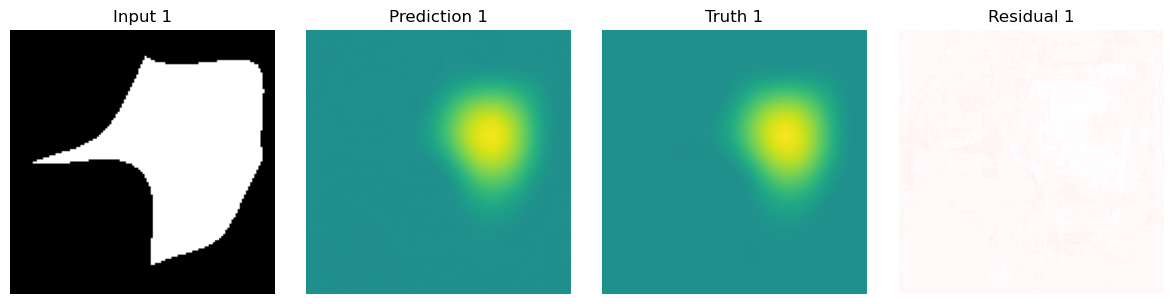

MSE (symmetric) between prediction 0 and truth: 0.000157


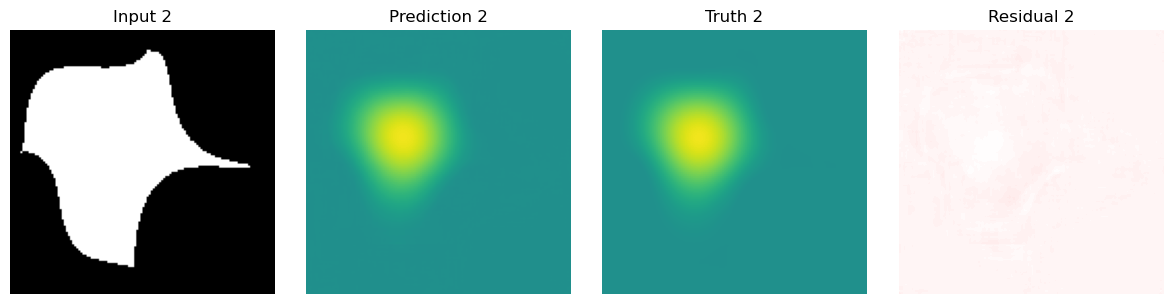

MSE (symmetric) between prediction 1 and truth: 0.000417


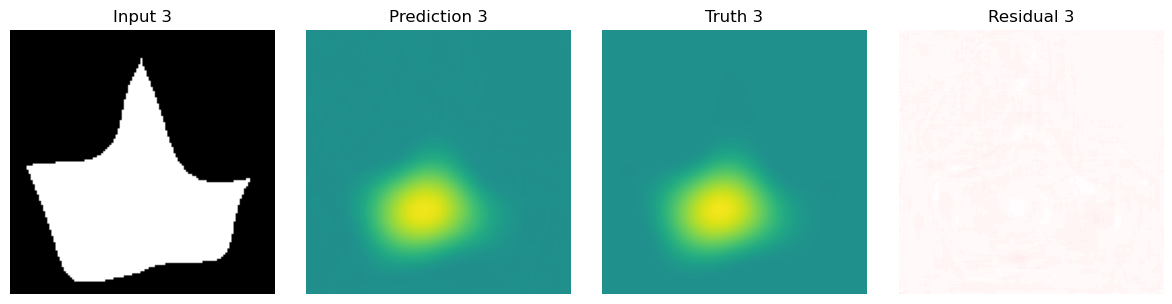

MSE (symmetric) between prediction 2 and truth: 0.000220


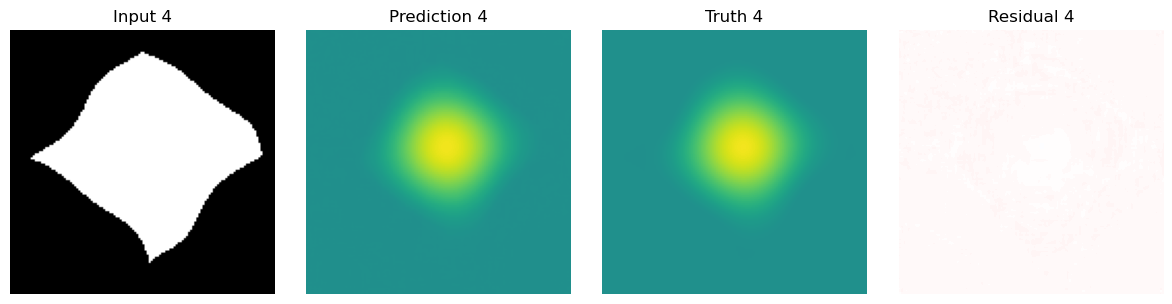

MSE (symmetric) between prediction 3 and truth: 0.000152


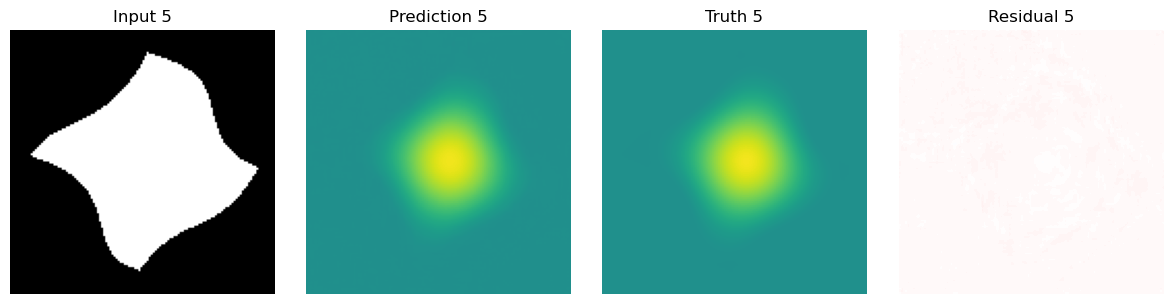

MSE (symmetric) between prediction 4 and truth: 0.000147


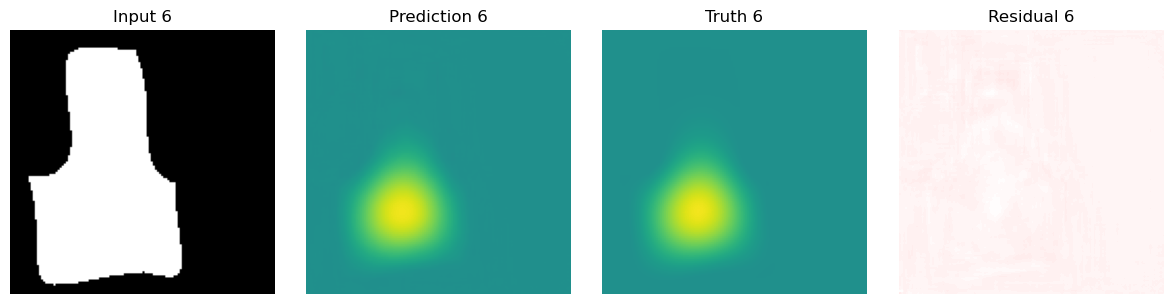

MSE (symmetric) between prediction 5 and truth: 0.000529


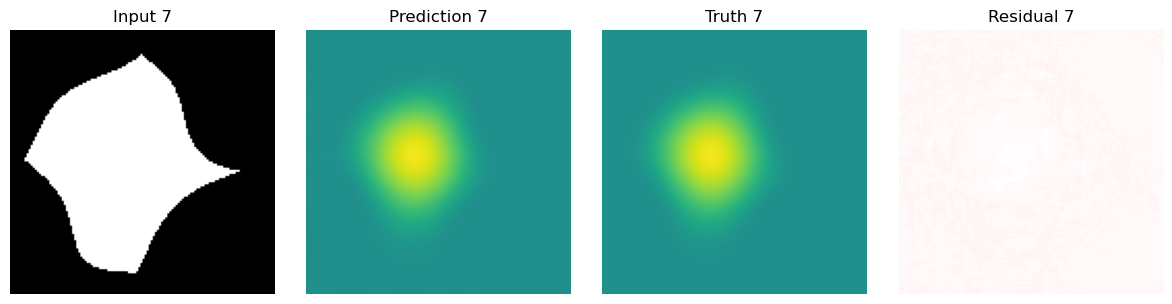

MSE (symmetric) between prediction 6 and truth: 0.000214


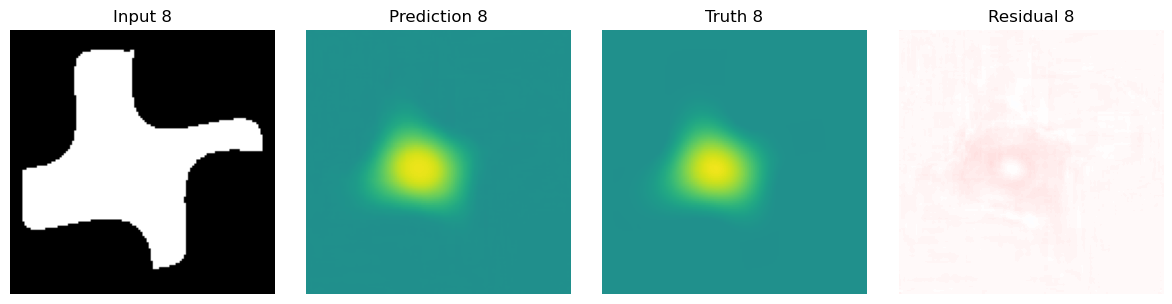

MSE (symmetric) between prediction 7 and truth: 0.000349


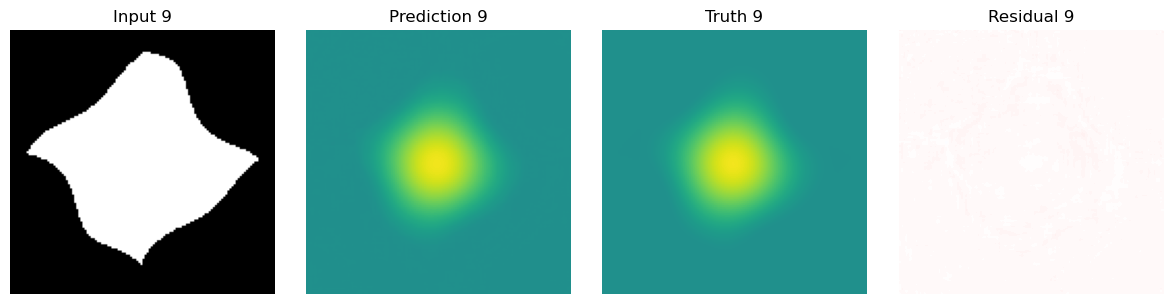

MSE (symmetric) between prediction 8 and truth: 0.000136


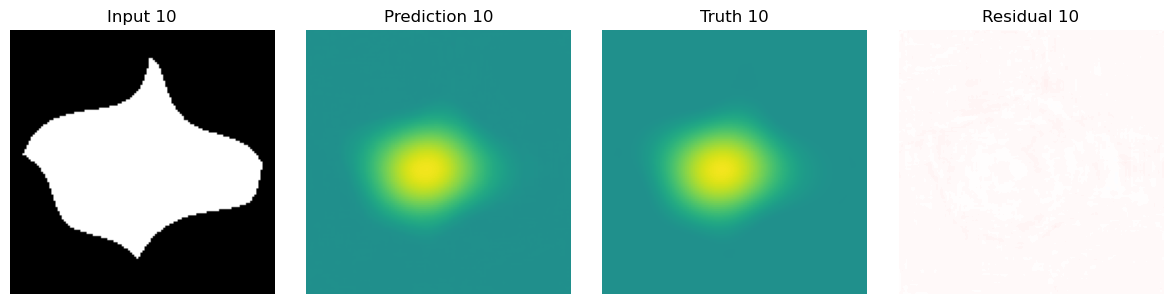

MSE (symmetric) between prediction 9 and truth: 0.000121


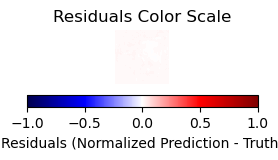

In [4]:
import numpy as np
from tensorflow.keras.models import load_model
import time

# Load the model
model_1 = load_model('regression_3phys_1_orth6modes.h5')
model_2 = load_model('regression_3phys_2_orth6modes.h5')
model_3 = load_model('regression_3phys_3_orth6modes.h5')
model_4 = load_model('regression_3phys_4_orth6modes.h5')
model_5 = load_model('regression_3phys_5_orth6modes.h5')
model_6 = load_model('regression_3phys_6_orth6modes.h5')

# start_time = time.time()
# Make predictions
#get the predictions for the test dataset
output_prediction_1 = model_1.predict([input_test_test,k_squared_test_test, output_test_test1, output_test_test2, output_test_test3, output_test_test4, output_test_test5])
output_prediction_2 = model_2.predict([input_test_test,k_squared_test_test, output_test_test1, output_test_test2, output_test_test3, output_test_test4, output_test_test5])
output_prediction_3 = model_3.predict([input_test_test,k_squared_test_test, output_test_test1, output_test_test2, output_test_test3, output_test_test4, output_test_test5])
output_prediction_4 = model_4.predict([input_test_test,k_squared_test_test, output_test_test1, output_test_test2, output_test_test3, output_test_test4, output_test_test5])
output_prediction_5 = model_5.predict([input_test_test,k_squared_test_test, output_test_test1, output_test_test2, output_test_test3, output_test_test4, output_test_test5])
output_prediction_6 = model_6.predict([input_test_test,k_squared_test_test, output_test_test1, output_test_test2, output_test_test3, output_test_test4, output_test_test5])

# end_time = time.time()
# time_comsumption = end_time - start_time
# print(f"time comsumption in prediction {len(input_test_test)} samples: {time_comsumption}")

import matplotlib.pyplot as plt


display_samples_line_by_line_with_residuals(input_test_test, output_prediction_1, output_test_test1, is_binary_input=True, is_binary_prediction=False, is_binary_truth=False)


In [23]:
def display_clean_colored_samples_with_best_residual(input_images, prediction_images, truth_images,
                                                     is_binary_input, is_binary_prediction, is_binary_truth):
    n = 1  # Number of samples to display
    residuals_all = []

    for i in range(n):
        # Original prediction and flipped version
        pred = prediction_images[i]
        pred_neg = -pred
        truth = truth_images[i]

        # Normalize for display
        norm_pred = (pred - np.min(pred)) / (np.max(pred) - np.min(pred) + 1e-8)
        norm_truth = (truth - np.min(truth)) / (np.max(truth) - np.min(truth) + 1e-8)
        norm_pred_neg = (pred_neg - np.min(pred_neg)) / (np.max(pred_neg) - np.min(pred_neg) + 1e-8)

        # MSE check for residual
        mse_pos = tf.reduce_mean(tf.keras.losses.MSE(norm_truth, norm_pred))
        mse_neg = tf.reduce_mean(tf.keras.losses.MSE(norm_truth, norm_pred_neg))

        if mse_neg < mse_pos:
            best_pred_for_residual = norm_pred_neg
        else:
            best_pred_for_residual = norm_pred

        residual = best_pred_for_residual - norm_truth
        residuals_all.append(residual)

        # Plot 4 columns
        plt.figure(figsize=(12, 3))

        # Input
        plt.subplot(1, 4, 1)
        plt.imshow(input_images[i], cmap='viridis', vmin=-1, vmax=1)
        plt.title(f"Input {i+1}")
        plt.axis("off")

        # Normalized Prediction (always original sign, color)
        plt.subplot(1, 4, 2)
        plt.imshow(pred, cmap='viridis', vmin=-1, vmax=1)
        plt.title("Norm. Prediction")
        plt.axis("off")

        # Normalized Truth (color)
        plt.subplot(1, 4, 3)
        plt.imshow(truth, cmap='viridis', vmin=-1, vmax=1)
        plt.title("Norm. Truth")
        plt.axis("off")

        # Residual (best-case, color)
        plt.subplot(1, 4, 4)
        im = plt.imshow(residual, cmap='viridis', vmin=-1, vmax=1)
        plt.title("Residual")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    # Shared vertical colorbar for residuals
    fig, ax = plt.subplots(figsize=(5, 15))
    im = ax.imshow(residuals_all[0], cmap='viridis', vmin=-1, vmax=1)
    cbar = plt.colorbar(im, orientation='vertical', fraction=0.05, pad=0.04)
    # cbar.set_label('Residual (Best Match - Norm. Truth)')
    num_ticks = 5
    cbar.set_ticks(np.linspace(-1, 1, num_ticks))
    ax.axis("off")
    plt.title("Residuals Color Scale", fontsize=10)
    plt.show()



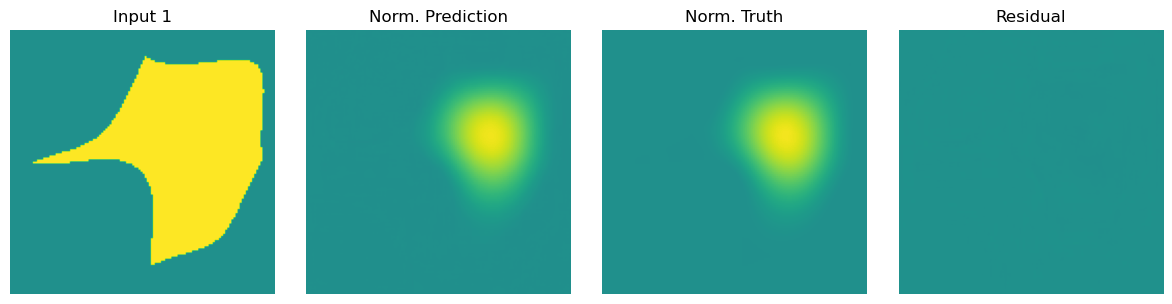

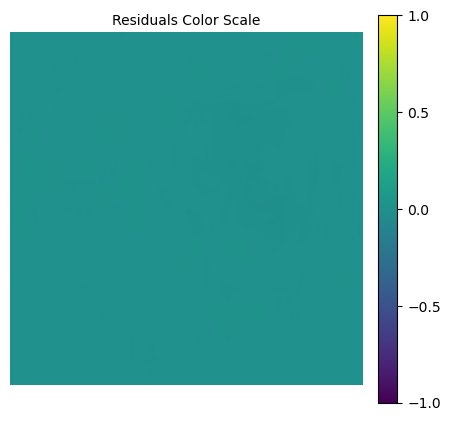

In [24]:
display_clean_colored_samples_with_best_residual(input_test_test, output_prediction_1, output_test_test1, is_binary_input=True, is_binary_prediction=False, is_binary_truth=False)